In [1]:
import numpy as np
import pandas as pd

# import GPUtil
# #imports from python 3.8
import tensorflow as tf
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import skew
from joblib import dump, load


## Get NVIDIA GPU Details

Get the information about the graphics card on the system for CUDA acceleration.

In [2]:
import subprocess

def get_gpu_details():
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True)
        output = result.stdout.decode('utf-8')
        print(output)
    except FileNotFoundError:
        print("nvidia-smi not found. Please make sure NVIDIA drivers are installed.")

# Call the function to display GPU details
get_gpu_details()

Sat May 18 14:03:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P5               7W /  54W |   3083MiB /  4096MiB |     23%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## List available GPU's on the system 

In [3]:
# import torch
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print("Device: ",device)
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# # export CUDA_VISIBLE_DEVICES=0
# GPUtil.getAvailable()
# use_cuda = torch.cuda.is_available()
# if use_cuda:
#     print('__CUDNN VERSION:', torch.backends.cudnn.version())
#     print('__Number CUDA Devices:', torch.cuda.device_count())
#     print('__CUDA Device Name:',torch.cuda.get_device_name(0))
#     print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
# else:
#     print("None")


print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import sys
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print(sys.version)
tf.test.is_gpu_available()

Tensorflow version: 2.10.0
3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Data Loading for ML

Here we load preprocessed data for a machine learning pipeline, which is a CNN model in our case.

In [18]:
df = pd.read_csv('./data/df_final_Task3_2.csv')

# X_train = pd.read_csv('./data/X_train_final.csv')
# Y_train = pd.read_csv('./data/Y_train_final.csv')
X_test = pd.read_csv('./data/X_test_Task3_2.csv')
Y_test = pd.read_csv('./data/Y_test_Task3_2.csv')
X_val = pd.read_csv('./data/X_val_Task3_2.csv')
Y_val = pd.read_csv('./data/Y_val_Task3_2.csv')

In [19]:
print("Train set shapes:", df.shape)
print("Test set shapes:", X_test.shape)
print("Validation set shapes:", X_val.shape)

Train set shapes: (20400, 3)
Test set shapes: (12201, 1)
Validation set shapes: (11753, 1)


## Hyperparameter Configuration

Here we define hyperparameters for training a CNN model for image classification with 6 output classes.

**Hyperparameters:**

| Parameter | Value | Description |
|---|---|---|
| BATCH_SIZE | 100 | Amount of images processed in each training step. |
| INPUT_DIM | (150, 150, 3) | Stats of the input images (height, width, channels): RGB images with 3 channels (data is preprocessed). |
| OUTPUT_CLASSES | 6 | Number of output classes for the model. |
| EPOCHS | 32 | Number of times the entire training dataset is passed through the model during training. |
| LEARNING_RATE | 1e-2 (0.01) | Controls the step size used to update model weights during training. |
| MOMENTUM | 0.9 | Used in gradient descent optimization to accelerate convergence and improve stability. |

In [20]:
# Model Parameters
BATCH_SIZE = 32
INPUT_DIM = (150, 150, 3)  # RGB - 3 channels images
OUTPUT_CLASSES = 6  
OUTPUT_STYLES = 17  # One-hot encoded: 8 different classes

# Training Parameters
EPOCHS = 32
LEARNING_RATE = 1e-2
MOMENTUM = 0.9

## Model Training: Image Data Augmentation and Generator Setup

Here we prepare data for training a CNN model using image data augmentation and generators in Keras/TensorFlow.

In [21]:
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pandas as pd


class FurnitureDataGenerator():
    """
    Data generator for a furniture dataset, which includes categories and styles.
    """
    def __init__(self, df, batch_size=32):
        self.df = df
        self.batch_size = batch_size
        
        # Label Encoders
        self.class_le = LabelEncoder()
        self.style_le = LabelEncoder()

        # Fit label encoders
        self.df['Class_id'] = self.class_le.fit_transform(self.df['Class'])
        self.df['Style_id'] = self.style_le.fit_transform(self.df['Style'])

        # Split indexes for training and validation
        self.train_idx, self.valid_idx = self.generate_split_indexes()

    def generate_split_indexes(self):
        """ Generate shuffled indexes for splitting the data into training and validation. """
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * 0.8)  # 80% training, 20% validation
        return p[:train_up_to], p[train_up_to:]

    def preprocess_image(self, img_path):
        """ Load and preprocess an image. """
        im = Image.open(img_path)
        im = im.resize((150, 150))  # Resize to the input size expected by the model
        im = np.array(im) / 255.0  # Normalize pixel values
        return im

    def generate_batches(self, image_idx, is_training=True):
        while True:  # Continuous loop
            if is_training:
                np.random.shuffle(image_idx)
        
            batch_input = []
            batch_output_class = []
            batch_output_style = []
        
            for idx in image_idx:
                entry = self.df.iloc[idx]
                image = self.preprocess_image(entry['ImgPath'])
                batch_input.append(image)
                batch_output_class.append(entry['Class_id'])
                batch_output_style.append(entry['Style_id'])
        
                if len(batch_input) == self.batch_size:
                    batch_x = np.array(batch_input)
                    batch_y_class = to_categorical(batch_output_class, num_classes=len(self.class_le.classes_))
                    batch_y_style = to_categorical(batch_output_style, num_classes=len(self.style_le.classes_))
                    yield batch_x, [batch_y_class, batch_y_style]
                    batch_input, batch_output_class, batch_output_style = [], [], []
            
            if not is_training:
                break
                # # Yield remaining data for the last batch if it exists
                # if batch_input:
                #     batch_x = np.array(batch_input)
                #     batch_y_class = to_categorical(batch_output_class, num_classes=len(self.class_le.classes_))
                #     batch_y_style = to_categorical(batch_output_style, num_classes=len(self.style_le.classes_))
                #     yield batch_x, [batch_y_class, batch_y_style]
                # # Loop around for validation
                # np.random.shuffle(image_idx)
    


In [42]:
df = pd.read_csv('./data/df_final_Task3_2.csv')
val_df = pd.concat([X_val, Y_val], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)

In [43]:
train_df = pd.concat([df, val_df], axis = 0)

In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32153 entries, 0 to 11752
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath  32153 non-null  object
 1   Class    32153 non-null  object
 2   Style    32153 non-null  object
dtypes: object(3)
memory usage: 1004.8+ KB


In [47]:
data_generator = FurnitureDataGenerator(train_df)
train_idx, valid_idx = data_generator.generate_split_indexes() 

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

class FurnitureMultiOutputModel:
    def __init__(self):
        pass

    def make_default_hidden_layers(self, inputs):
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        
        return x

    def build_category_branch(self, inputs, num_categories):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_categories, activation="softmax", name="category_output")(x)
        return x

    def build_style_branch(self, inputs, num_styles):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_styles, activation="softmax", name="style_output")(x)
        return x

    def assemble_full_model(self, width, height, num_categories, num_styles):
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        
        category_branch = self.build_category_branch(inputs, num_categories)
        style_branch = self.build_style_branch(inputs, num_styles)
        
        model = Model(inputs=inputs, outputs=[category_branch, style_branch], name="furniture_net")
        
        return model

# Example usage:
num_categories = 6  # For example, beds, chairs, dressers, lamps, sofas, tables
num_styles = 17  # Number of furniture styles
model = FurnitureMultiOutputModel().assemble_full_model(150, 150, num_categories, num_styles)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={
                  'category_output': 'categorical_crossentropy',
                  'style_output': 'categorical_crossentropy'
              },
              loss_weights={
                  'category_output': 1.0, 
                  'style_output': 3.0},
              metrics={
                  'category_output': 'accuracy',
                  'style_output': 'accuracy'
              })


In [66]:
batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_batches(train_idx, is_training=True)
valid_gen = data_generator.generate_batches(valid_idx, is_training=True)

In [67]:
validation_steps=len(valid_idx)//valid_batch_size
# print(validation_steps)
steps_per_epoch = len(train_idx)//batch_size
print(steps_per_epoch, validation_steps)

803 200


In [68]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
reduce_lr = ReduceLROnPlateau(monitor='val_style_output_accuracy', factor=0.2, patience=5, min_lr=0.0001)

# Check for available GPUs.
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

# Print the device being used
print("Training using:", device)

# Context manager that specifies the device to use for operations
with tf.device(device):
    history = model.fit(
        train_gen,
        steps_per_epoch = steps_per_epoch,
        epochs=32,  # Ensure epochs variable is defined or replace with a fixed number
        callbacks=[reduce_lr],
        validation_data=valid_gen,
        validation_steps=validation_steps
    )


Training using: /GPU:0
Epoch 1/32
803/803 [==============================] - 148s 181ms/step - loss: 9.3623 - category_output_loss: 0.9882 - style_output_loss: 2.7914 - category_output_accuracy: 0.6545 - style_output_accuracy: 0.1440 - val_loss: 10.0018 - val_category_output_loss: 1.6693 - val_style_output_loss: 2.7775 - val_category_output_accuracy: 0.3364 - val_style_output_accuracy: 0.1120 - lr: 0.0010
Epoch 2/32
803/803 [==============================] - 147s 183ms/step - loss: 8.0101 - category_output_loss: 0.6834 - style_output_loss: 2.4422 - category_output_accuracy: 0.7725 - style_output_accuracy: 0.2042 - val_loss: 7.9517 - val_category_output_loss: 0.6875 - val_style_output_loss: 2.4214 - val_category_output_accuracy: 0.7675 - val_style_output_accuracy: 0.2225 - lr: 0.0010
Epoch 3/32
803/803 [==============================] - 148s 185ms/step - loss: 7.6042 - category_output_loss: 0.5651 - style_output_loss: 2.3464 - category_output_accuracy: 0.8158 - style_output_accuracy: 0.

KeyboardInterrupt: 

In [165]:
# Save history
dump(history, 'history_model4_Task3.joblib')
# Save model
model.save('model4_Task3.h5')

INFO:tensorflow:Assets written to: ram://57cb3103-60fe-4fe0-a6a9-5c632b2208d8/assets


INFO:tensorflow:Assets written to: ram://57cb3103-60fe-4fe0-a6a9-5c632b2208d8/assets


## Experiment 5

In [18]:
train_df = pd.read_csv('./data/df_final_Task3_2.csv')
val_df = pd.concat([X_val, Y_val], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)

In [19]:
df = pd.concat([train_df, val_df], axis = 0)

In [20]:
df = pd.concat([df, test_df], axis = 0)

In [21]:
from sklearn.utils import shuffle
df = shuffle(df, random_state = 42)
df.reset_index(inplace=True, drop=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44354 entries, 0 to 44353
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath  44354 non-null  object
 1   Class    44354 non-null  object
 2   Style    44354 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [23]:
df.head()

,ImgPath,Class,Style
0,data/Furniture_Data\chairs\Transitional\5512tr...,chairs,Transitional
1,data/Furniture_Data\chairs\Contemporary\15cont...,chairs,Contemporary
2,data/Furniture_Data\lamps\Asian\18060asian-tab...,lamps,Asian
3,data/Furniture_Data\sofas\Midcentury\2838midce...,sofas,Midcentury
4,data/Furniture_Data\lamps\Craftsman\27623craft...,lamps,Craftsman


In [24]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame
class_encoder = LabelEncoder()
style_encoder = LabelEncoder()

df['Class_id'] = class_encoder.fit_transform(df['Class'])
df['Style_id'] = style_encoder.fit_transform(df['Style'])



In [25]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

class FurnitureDataGenerator():
    """
    Data generator for a furniture dataset, which includes categories and styles.
    """
    def __init__(self, df, batch_size=32):
        self.df = df
        self.batch_size = batch_size
        
    def preprocess_image(self, img_path):
        """ Load and preprocess an image. """
        im = Image.open(img_path)
        im = im.resize((150, 150))  # Resize to the input size expected by the model
        im = np.array(im) / 255.0  # Normalize pixel values
        return im

    def generate_batches(self, image_idx, is_training=True):
        while True:  # Continuous loop
            if is_training:
                np.random.shuffle(image_idx)
        
            batch_input = []
            batch_output_class = []
            batch_output_style = []
        
            for idx in image_idx:
                entry = self.df.iloc[idx]
                image = self.preprocess_image(entry['ImgPath'])
                batch_input.append(image)
                batch_output_class.append(entry['Class_id'])
                batch_output_style.append(entry['Style_id'])
        
                if len(batch_input) == self.batch_size:
                    batch_x = np.array(batch_input)
                    batch_y_class = to_categorical(batch_output_class, num_classes=len(class_encoder.classes_))
                    batch_y_style = to_categorical(batch_output_style, num_classes=len(style_encoder.classes_))
                    yield batch_x, [batch_y_class, batch_y_style]
                    batch_input, batch_output_class, batch_output_style = [], [], []
            
            if not is_training:
                # Yield remaining data for the last batch if it exists
                if batch_input:
                    batch_x = np.array(batch_input)
                    batch_y_class = to_categorical(batch_output_class, num_classes=len(class_encoder.classes_))
                    batch_y_style = to_categorical(batch_output_style, num_classes=len(style_encoder.classes_))
                    yield batch_x, [batch_y_class, batch_y_style]
                # Loop around for validation
                np.random.shuffle(image_idx)

# Example usage:
batch_size = 32
train_idx = list(range(len(df)))[:int(0.7 * len(df))]  # 70% training data
val_idx = list(range(len(df)))[int(0.7 * len(df)):int(0.85 * len(df))]  # 15% validation data
test_idx = list(range(len(df)))[int(0.85 * len(df)):]  # 15% test data

train_datagen = FurnitureDataGenerator(df, batch_size=batch_size)
val_datagen = FurnitureDataGenerator(df, batch_size=batch_size)

train_generator = train_datagen.generate_batches(train_idx)
val_generator = val_datagen.generate_batches(val_idx, is_training=False)


In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

class FurnitureMultiOutputModel:
    def __init__(self):
        pass

    def make_default_hidden_layers(self, inputs):
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(256, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.5)(x)
        
        return x

    def build_category_branch(self, inputs, num_categories):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_categories, activation="softmax", name="category_output")(x)
        return x

    def build_style_branch(self, inputs, num_styles):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(256, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(num_styles, activation="softmax", name="style_output")(x)
        return x

    def assemble_full_model(self, width, height, num_categories, num_styles):
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        
        category_branch = self.build_category_branch(inputs, num_categories)
        style_branch = self.build_style_branch(inputs, num_styles)
        
        model = Model(inputs=inputs, outputs=[category_branch, style_branch], name="furniture_net")
        
        return model

# Example usage:
num_categories = 6  # For example, beds, chairs, dressers, lamps, sofas, tables
num_styles = 17  # Number of furniture styles
model = FurnitureMultiOutputModel().assemble_full_model(150, 150, num_categories, num_styles)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={
                  'category_output': 'categorical_crossentropy',
                  'style_output': 'categorical_crossentropy'
              },
              loss_weights={
                  'category_output': 1.0, 
                  'style_output': 2.5,
              },
              metrics={
                  'category_output': 'accuracy',
                  'style_output': 'accuracy'
              })


In [27]:
print(len(train_idx) // batch_size)
print(len(val_idx) // batch_size)

970
207


In [28]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_style_output_accuracy', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Check for available GPUs.
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

# Print the device being used
print("Training using:", device)

# Context manager that specifies the device to use for operations
with tf.device(device):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_idx) // batch_size,
        epochs=32,
        validation_data=val_generator,
        validation_steps=len(val_idx) // batch_size,
        callbacks=[reduce_lr, early_stopping]
    )

Training using: /GPU:0
Epoch 1/32
970/970 [==============================] - 196s 199ms/step - loss: 6.8342 - category_output_loss: 0.8669 - style_output_loss: 2.3869 - category_output_accuracy: 0.7063 - style_output_accuracy: 0.2303 - val_loss: 6.9359 - val_category_output_loss: 0.5951 - val_style_output_loss: 2.5363 - val_category_output_accuracy: 0.7950 - val_style_output_accuracy: 0.1883 - lr: 0.0010
Epoch 2/32
970/970 [==============================] - 192s 198ms/step - loss: 5.9277 - category_output_loss: 0.5728 - style_output_loss: 2.1419 - category_output_accuracy: 0.8147 - style_output_accuracy: 0.3050 - val_loss: 7.7544 - val_category_output_loss: 0.6936 - val_style_output_loss: 2.8244 - val_category_output_accuracy: 0.7607 - val_style_output_accuracy: 0.1984 - lr: 0.0010
Epoch 3/32
970/970 [==============================] - 179s 184ms/step - loss: 5.5849 - category_output_loss: 0.5210 - style_output_loss: 2.0256 - category_output_accuracy: 0.8315 - style_output_accuracy: 0.3

In [29]:
# Save history
dump(history, 'history_model5_Task3.joblib')
# Save model
model.save('model5_Task3.h5')

INFO:tensorflow:Assets written to: ram://fd4667b0-ee5f-49b8-b76f-677bf58ec7b8/assets


INFO:tensorflow:Assets written to: ram://fd4667b0-ee5f-49b8-b76f-677bf58ec7b8/assets


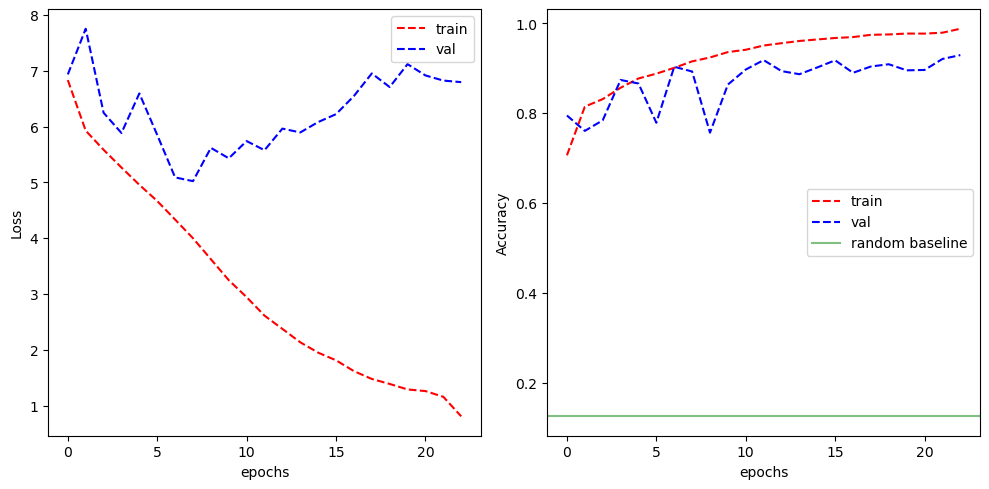

In [33]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['category_output_accuracy'],
    history.history['val_category_output_accuracy'],
    # to_file=f'images/{plot_name}-LearningCurve.png'
)

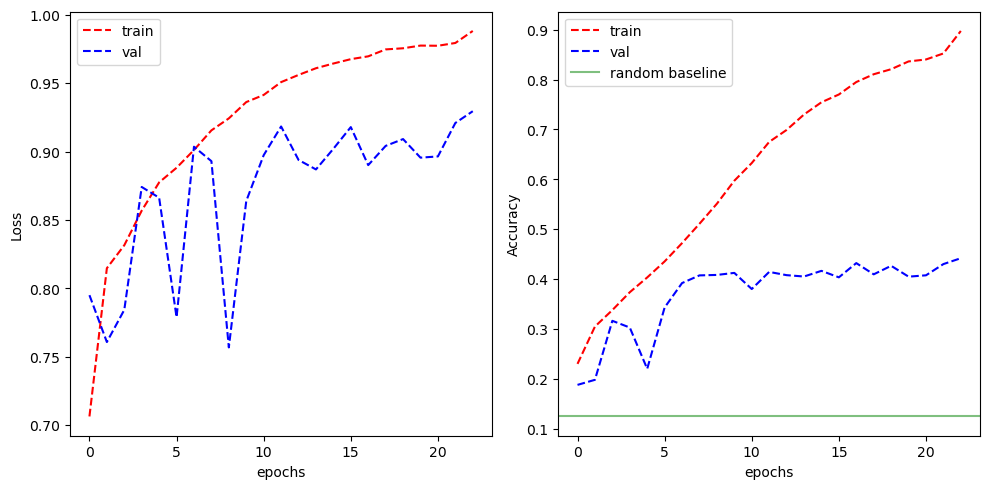

In [36]:
plot_learning_curve(
    history.history['category_output_accuracy'],
    history.history['val_category_output_accuracy'],
    history.history['style_output_accuracy'],
    history.history['val_style_output_accuracy'],
    # to_file=f'images/{plot_name}-LearningCurve.png'
)

## Experiment 6

In [8]:
df = pd.read_csv('./data/df_clean_Task3.csv')

In [9]:
from sklearn.utils import shuffle
df = shuffle(df, random_state = 42)
df.reset_index(inplace=True, drop=True)

In [10]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame
class_encoder = LabelEncoder()
style_encoder = LabelEncoder()

df['Class_id'] = class_encoder.fit_transform(df['Class'])
df['Style_id'] = style_encoder.fit_transform(df['Style'])

In [11]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

class FurnitureDataGenerator():
    """
    Data generator for a furniture dataset, which includes categories and styles.
    """
    def __init__(self, df, batch_size=32):
        self.df = df
        self.batch_size = batch_size
        
    def preprocess_image(self, img_path):
        """ Load and preprocess an image. """
        im = Image.open(img_path)
        im = im.resize((150, 150))  # Resize to the input size expected by the model
        im = np.array(im) / 255.0  # Normalize pixel values
        return im

    def generate_batches(self, image_idx, is_training=True):
        while True:  # Continuous loop
            if is_training:
                np.random.shuffle(image_idx)
        
            batch_input = []
            batch_output_class = []
            batch_output_style = []
        
            for idx in image_idx:
                entry = self.df.iloc[idx]
                image = self.preprocess_image(entry['ImgPath'])
                batch_input.append(image)
                batch_output_class.append(entry['Class_id'])
                batch_output_style.append(entry['Style_id'])
        
                if len(batch_input) == self.batch_size:
                    batch_x = np.array(batch_input)
                    batch_y_class = to_categorical(batch_output_class, num_classes=len(class_encoder.classes_))
                    batch_y_style = to_categorical(batch_output_style, num_classes=len(style_encoder.classes_))
                    yield batch_x, [batch_y_class, batch_y_style]
                    batch_input, batch_output_class, batch_output_style = [], [], []
            
            if not is_training:
                # Yield remaining data for the last batch if it exists
                if batch_input:
                    batch_x = np.array(batch_input)
                    batch_y_class = to_categorical(batch_output_class, num_classes=len(class_encoder.classes_))
                    batch_y_style = to_categorical(batch_output_style, num_classes=len(style_encoder.classes_))
                    yield batch_x, [batch_y_class, batch_y_style]
                # Loop around for validation
                np.random.shuffle(image_idx)

# Example usage:
batch_size = 32
train_idx = list(range(len(df)))[:int(0.7 * len(df))]  # 70% training data
val_idx = list(range(len(df)))[int(0.7 * len(df)):int(0.85 * len(df))]  # 15% validation data
test_idx = list(range(len(df)))[int(0.85 * len(df)):]  # 15% test data

train_datagen = FurnitureDataGenerator(df, batch_size=batch_size)
val_datagen = FurnitureDataGenerator(df, batch_size=batch_size)

train_generator = train_datagen.generate_batches(train_idx)
val_generator = val_datagen.generate_batches(val_idx, is_training=False)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

class FurnitureMultiOutputModel:
    def __init__(self):
        pass

    def make_default_hidden_layers(self, inputs):
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.5)(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.5)(x)

        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.5)(x)

        x = Conv2D(256, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.5)(x)
        
        return x

    def build_category_branch(self, inputs, num_categories):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu", kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_categories, activation="softmax", name="category_output")(x)
        return x

    def build_style_branch(self, inputs, num_styles):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(256, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_styles, activation="softmax", name="style_output")(x)
        return x

    def assemble_full_model(self, width, height, num_categories, num_styles):
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        
        category_branch = self.build_category_branch(inputs, num_categories)
        style_branch = self.build_style_branch(inputs, num_styles)
        
        model = Model(inputs=inputs, outputs=[category_branch, style_branch], name="furniture_net")
        
        return model

# Example usage:
num_categories = 6  # For example, beds, chairs, dressers, lamps, sofas, tables
num_styles = 17  # Number of furniture styles
model = FurnitureMultiOutputModel().assemble_full_model(150, 150, num_categories, num_styles)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={
                  'category_output': 'categorical_crossentropy',
                  'style_output': 'categorical_crossentropy'
              },
              loss_weights={
                  'category_output': 1.0, 
                  'style_output': 2.5,
              },
              metrics={
                  'category_output': 'accuracy',
                  'style_output': 'accuracy'
              })


In [13]:
# batch_size = 32
# valid_batch_size = 32

In [14]:
print(len(train_idx) // batch_size)
print(len(val_idx) // batch_size)

1779
381


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_style_output_accuracy', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Check for available GPUs.
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

# Print the device being used
print("Training using:", device)

# Context manager that specifies the device to use for operations
with tf.device(device):
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_idx) // batch_size,
        epochs=32,
        validation_data=val_generator,
        validation_steps=len(val_idx) // batch_size,
        callbacks=[reduce_lr, early_stopping]
    )

Training using: /GPU:0
Epoch 1/32
1779/1779 [==============================] - 489s 268ms/step - loss: 8.3518 - category_output_loss: 0.6514 - style_output_loss: 2.3031 - category_output_accuracy: 0.7950 - style_output_accuracy: 0.2733 - val_loss: 7.9141 - val_category_output_loss: 1.6432 - val_style_output_loss: 2.1957 - val_category_output_accuracy: 0.4912 - val_style_output_accuracy: 0.2809 - lr: 0.0010
Epoch 2/32
1779/1779 [==============================] - 490s 276ms/step - loss: 6.0166 - category_output_loss: 0.4703 - style_output_loss: 1.9635 - category_output_accuracy: 0.8586 - style_output_accuracy: 0.3605 - val_loss: 6.6569 - val_category_output_loss: 1.2114 - val_style_output_loss: 1.9370 - val_category_output_accuracy: 0.5516 - val_style_output_accuracy: 0.3671 - lr: 0.0010
Epoch 3/32
1779/1779 [==============================] - 356s 200ms/step - loss: 5.5802 - category_output_loss: 0.4012 - style_output_loss: 1.8554 - category_output_accuracy: 0.8811 - style_output_accurac

In [17]:
# Save history
dump(history, 'history_model6_Task3.joblib')
# Save model
model.save('model6_Task3.h5')

INFO:tensorflow:Assets written to: ram://a8496603-8964-4851-af9d-eaf483818ccc/assets


INFO:tensorflow:Assets written to: ram://a8496603-8964-4851-af9d-eaf483818ccc/assets


In [30]:
def plot_learning_curve(
        train_loss, val_loss, train_metric, val_metric,
        to_file: str = None
) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].plot(train_loss, 'r--')
    ax[0].plot(val_loss, 'b--')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend(['train', 'val'])

    ax[1].plot(train_metric, 'r--')
    ax[1].plot(val_metric, 'b--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].axhline(y=0.125, c='g', alpha=0.5)  # Random probability - naive classifier
    ax[1].legend(['train', 'val', 'random baseline'])

    fig.tight_layout()
    plt.show()
    if to_file is not None:
        fig.savefig(to_file)

In [14]:
history  load('history_model6_Task3.joblib')
plot_name = 'clf-cnn1'
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['category_output_accuracy'],
    history.history['val_category_output_accuracy'],
    # to_file=f'images/{plot_name}-LearningCurve.png'
)

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://49726d5f-16ce-47fb-97d1-e92f504c3e37/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

## Experiment 7


In [16]:
train_datagen = FurnitureDataGenerator(train_df)
val_datagen = FurnitureDataGenerator(val_df)
train_generator = train_datagen.generate_batches(train_datagen.train_idx)
val_generator = val_datagen.generate_batches(val_datagen.valid_idx, is_training=False)

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

class FurnitureMultiOutputModel:
    def __init__(self):
        pass

    def make_default_hidden_layers(self, inputs):
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.5)(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.5)(x)

        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.5)(x)

        x = Conv2D(256, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.5)(x)
        
        return x

    def build_category_branch(self, inputs, num_categories):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(256, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_categories, activation="softmax", name="category_output")(x)
        return x

    def build_style_branch(self, inputs, num_styles):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(256, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        # x = Dropout(0.5)(x)
        x = Dense(num_styles, activation="softmax", name="style_output")(x)
        return x

    def assemble_full_model(self, width, height, num_categories, num_styles):
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        
        category_branch = self.build_category_branch(inputs, num_categories)
        style_branch = self.build_style_branch(inputs, num_styles)
        
        model = Model(inputs=inputs, outputs=[category_branch, style_branch], name="furniture_net")
        
        return model

# Example usage:
num_categories = 6  # For example, beds, chairs, dressers, lamps, sofas, tables
num_styles = 17  # Number of furniture styles
model = FurnitureMultiOutputModel().assemble_full_model(150, 150, num_categories, num_styles)
model.compile(optimizer=Adam(learning_rate=0.01),
              loss={
                  'category_output': 'categorical_crossentropy',
                  'style_output': 'categorical_crossentropy'
              },
              metrics={
                  'category_output': 'accuracy',
                  'style_output': 'accuracy'
              })


In [22]:
batch_size = 32
valid_batch_size = 32

In [23]:
validation_steps = max(1, len(val_datagen.valid_idx) // valid_batch_size)
# print(validation_steps)
steps_per_epoch = (len(train_datagen.train_idx) + train_datagen.batch_size - 1) // train_datagen.batch_size
validation_steps = (len(val_datagen.valid_idx) + valid_batch_size - 1) // valid_batch_size
print(steps_per_epoch, validation_steps)

1275 102


In [24]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
callbacks = [
    ModelCheckpoint("./model_Task3_checkpoint5", monitor='val_loss')
]

# Check for available GPUs.
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

# Print the device being used
print("Training using:", device)

# Context manager that specifies the device to use for operations
with tf.device(device):
    history = model.fit(
        train_generator,
        steps_per_epoch = steps_per_epoch,
        epochs=32,  # Ensure epochs variable is defined or replace with a fixed number
        # callbacks=callbacks,
        validation_data=val_generator,
        validation_steps=validation_steps
    )


Training using: /GPU:0
Epoch 1/32
1275/1275 [==============================] - 253s 196ms/step - loss: 3.8929 - category_output_loss: 1.1984 - style_output_loss: 2.5312 - category_output_accuracy: 0.5647 - style_output_accuracy: 0.1704 - val_loss: 5.0981 - val_category_output_loss: 0.9978 - val_style_output_loss: 3.9985 - val_category_output_accuracy: 0.6291 - val_style_output_accuracy: 0.0983
Epoch 2/32
1275/1275 [==============================] - 229s 179ms/step - loss: 3.4917 - category_output_loss: 1.0364 - style_output_loss: 2.3503 - category_output_accuracy: 0.6408 - style_output_accuracy: 0.2336 - val_loss: 3.1585 - val_category_output_loss: 0.6538 - val_style_output_loss: 2.4090 - val_category_output_accuracy: 0.7575 - val_style_output_accuracy: 0.1841
Epoch 3/32
1275/1275 [==============================] - 224s 176ms/step - loss: 3.2601 - category_output_loss: 0.9324 - style_output_loss: 2.2516 - category_output_accuracy: 0.6772 - style_output_accuracy: 0.2707 - val_loss: 2.91

In [25]:
# Save history
dump(history, 'history_model7_Task3.joblib')
# Save model
model.save('model7_Task3.h5')

INFO:tensorflow:Assets written to: ram://271deff3-1162-4860-a82c-b5341f22b689/assets


INFO:tensorflow:Assets written to: ram://271deff3-1162-4860-a82c-b5341f22b689/assets


## Experiment 8

In [11]:
train_datagen = FurnitureDataGenerator(train_df)
val_datagen = FurnitureDataGenerator(val_df)
train_generator = train_datagen.generate_batches(train_datagen.train_idx)
val_generator = val_datagen.generate_batches(val_datagen.valid_idx, is_training=False)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def build_simple_vgg(input_shape, num_classes, num_styles):
    inputs = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 2
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 3
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Block 4
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    # Flatten
    x = Flatten()(x)
    
    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    shared_output = x
    
    # Category output
    category_branch = Dense(256, activation='relu')(shared_output)
    category_branch = Dropout(0.5)(category_branch)
    category_output = Dense(num_classes, activation='softmax', name='category_output')(category_branch)
    
    # Style output
    style_branch = Dense(256, activation='relu')(shared_output)
    style_branch = Dropout(0.5)(style_branch)
    style_output = Dense(num_styles, activation='softmax', name='style_output')(style_branch)
    
    model = Model(inputs=inputs, outputs=[category_output, style_output])
    return model

# Define the model
input_shape = (150, 150, 3)
num_classes = 6  # For example, beds, chairs, dressers, lamps, sofas, tables
num_styles = 17  # Number of furniture styles

model = build_simple_vgg(input_shape, num_classes, num_styles)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={
                  'category_output': 'categorical_crossentropy',
                  'style_output': 'categorical_crossentropy'
              },
              metrics={
                  'category_output': 'accuracy',
                  'style_output': 'accuracy'
              })


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 150, 150, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [14]:
batch_size = 32
valid_batch_size = 32
validation_steps = max(1, len(val_datagen.valid_idx) // valid_batch_size)
steps_per_epoch = (len(train_datagen.train_idx) + train_datagen.batch_size - 1) // train_datagen.batch_size
validation_steps = (len(val_datagen.valid_idx) + valid_batch_size - 1) // valid_batch_size
print(steps_per_epoch, validation_steps)

1275 102


In [15]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Check for available GPUs.
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

# Print the device being used
print("Training using:", device)

# Context manager that specifies the device to use for operations
with tf.device(device):
    history = model.fit(
        train_generator,
        steps_per_epoch = len(train_datagen.train_idx) // train_datagen.batch_size,
        epochs=32,  # Ensure epochs variable is defined or replace with a fixed number
        validation_data=val_generator,
        validation_steps = len(val_datagen.valid_idx) // val_datagen.batch_size,
        callbacks=[reduce_lr, early_stopping]
    )

Training using: /GPU:0
Epoch 1/32
1275/1275 [==============================] - 308s 235ms/step - loss: 4.6263 - category_output_loss: 1.7923 - style_output_loss: 2.8341 - category_output_accuracy: 0.1676 - style_output_accuracy: 0.0597 - val_loss: 4.6252 - val_category_output_loss: 1.7938 - val_style_output_loss: 2.8313 - val_category_output_accuracy: 0.2076 - val_style_output_accuracy: 0.0254 - lr: 0.0010
Epoch 2/32
1251/1275 [============================>.] - ETA: 4s - loss: 4.6255 - category_output_loss: 1.7919 - style_output_loss: 2.8336 - category_output_accuracy: 0.1674 - style_output_accuracy: 0.0592

KeyboardInterrupt: 

In [ ]:
# Save history
dump(history, 'history_model8_Task3.joblib')
# Save model
model.save('model8_Task3.h5')

## Experiment 9

In [30]:
val_df = pd.concat([X_val, Y_val], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)

In [31]:
train_df = pd.concat([df, val_df], axis=0)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath  51000 non-null  object
 1   Class    51000 non-null  object
 2   Style    51000 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67267 entries, 0 to 16266
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath  67267 non-null  object
 1   Class    67267 non-null  object
 2   Style    67267 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB


In [34]:
train_datagen = FurnitureDataGenerator(train_df)
train_generator = train_datagen.generate_batches(train_datagen.train_idx)
val_generator = train_datagen.generate_batches(train_datagen.valid_idx, is_training=False)

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam

class FurnitureMultiOutputModel:
    def __init__(self):
        pass

    def residual_block(self, x, filters, kernel_size=3):
        shortcut = x
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x

    def make_shared_hidden_layers(self, inputs):
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = Conv2D(256, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        x = self.residual_block(x, 256)
        
        return x

    def build_category_branch(self, inputs, num_categories):
        x = self.make_shared_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_categories, activation="softmax", name="category_output")(x)
        return x

    def build_style_branch(self, inputs, num_styles):
        x = self.make_shared_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(256, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_styles, activation="softmax", name="style_output")(x)
        return x

    def assemble_full_model(self, width, height, num_categories, num_styles):
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        
        category_branch = self.build_category_branch(inputs, num_categories)
        style_branch = self.build_style_branch(inputs, num_styles)
        
        model = Model(inputs=inputs, outputs=[category_branch, style_branch], name="furniture_net")
        
        return model

# Example usage:
num_categories = 6  # For example, beds, chairs, dressers, lamps, sofas, tables
num_styles = 17  # Number of furniture styles
model = FurnitureMultiOutputModel().assemble_full_model(150, 150, num_categories, num_styles)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={
                  'category_output': 'categorical_crossentropy',
                  'style_output': 'categorical_crossentropy'
              },
              metrics={
                  'category_output': 'accuracy',
                  'style_output': 'accuracy'
              })


In [36]:
batch_size = 32
valid_batch_size = 32
validation_steps = max(1, len(train_datagen.valid_idx) // valid_batch_size)
steps_per_epoch = (len(train_datagen.train_idx) + train_datagen.batch_size - 1) // train_datagen.batch_size
validation_steps = (len(train_datagen.valid_idx) + valid_batch_size - 1) // valid_batch_size
print(steps_per_epoch, validation_steps)

1682 421


In [37]:
# Train the model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32


# Check for available GPUs.
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

# Print the device being used
print("Training using:", device)

# Context manager that specifies the device to use for operations
with tf.device(device):
    history = model.fit(
        train_generator,
        steps_per_epoch = steps_per_epoch,
        epochs=32,  # Ensure epochs variable is defined or replace with a fixed number
        callbacks=[reduce_lr, early_stopping],
        validation_data=val_generator,
        validation_steps = validation_steps
    )

Training using: /GPU:0
Epoch 1/32
1682/1682 [==============================] - 578s 342ms/step - loss: 3.4922 - category_output_loss: 0.9069 - style_output_loss: 2.5853 - category_output_accuracy: 0.6869 - style_output_accuracy: 0.1797 - val_loss: 3.1561 - val_category_output_loss: 0.7370 - val_style_output_loss: 2.4191 - val_category_output_accuracy: 0.7373 - val_style_output_accuracy: 0.1846 - lr: 0.0010
Epoch 2/32
1682/1682 [==============================] - 546s 324ms/step - loss: 2.8690 - category_output_loss: 0.5706 - style_output_loss: 2.2984 - category_output_accuracy: 0.8176 - style_output_accuracy: 0.2592 - val_loss: 2.6999 - val_category_output_loss: 0.5787 - val_style_output_loss: 2.1212 - val_category_output_accuracy: 0.7981 - val_style_output_accuracy: 0.3293 - lr: 0.0010
Epoch 3/32
1682/1682 [==============================] - 497s 295ms/step - loss: 2.5933 - category_output_loss: 0.4319 - style_output_loss: 2.1614 - category_output_accuracy: 0.8662 - style_output_accurac

KeyboardInterrupt: 

In [23]:
# Save history
dump(history, 'history_model9_Task3.joblib')
# Save model
model.save('model9_Task3.h5')

INFO:tensorflow:Assets written to: ram://fd6f3856-ddc9-4823-bb40-5fafcc34eabd/assets


INFO:tensorflow:Assets written to: ram://fd6f3856-ddc9-4823-bb40-5fafcc34eabd/assets


## Experiment 10

In [9]:
df = pd.read_csv('./data/df_final_Task3_2.csv')

In [10]:
val_df = pd.concat([X_val, Y_val], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)
train_df = df

In [11]:
train_df.head()

,ImgPath,Class,Style
0,augmentation_Task3_2\beds\Asian\8109asian-pane...,beds,Asian
1,augmentation_Task3_2\beds\Asian\3110asian-plat...,beds,Asian
2,augmentation_Task3_2\beds\Asian\3368asian-pane...,beds,Asian
3,augmentation_Task3_2\beds\Asian\7957asian-plat...,beds,Asian
4,augmentation_Task3_2\beds\Asian\8109asian-pane...,beds,Asian


In [12]:
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import pandas as pd

class FurnitureDataGenerator():
    """
    Data generator for a furniture dataset, which includes categories and styles.
    """
    def __init__(self, df, batch_size=32):
        self.df = df
        self.batch_size = batch_size
        
        # Label Encoders
        self.class_le = LabelEncoder()
        self.furniture_le = LabelEncoder()

        # Fit label encoders
        self.df['Class_id'] = self.class_le.fit_transform(self.df['Class'])
        self.df['Style_id'] = self.furniture_le.fit_transform(self.df['Style'])

    def preprocess_image(self, img_path):
        """ Load and preprocess an image. """
        im = Image.open(img_path)
        im = im.resize((150, 150))  # Resize to the input size expected by the model
        im = np.array(im) / 255.0  # Normalize pixel values
        return im

    def generate_batches(self, image_idx, is_training=True):
        image_idx = list(image_idx)  # Convert range object to list
        while True:  # Continuous loop
            if is_training:
                np.random.shuffle(image_idx)
        
            batch_input = []
            batch_output_class = []
            batch_output_style = []
        
            for idx in image_idx:
                entry = self.df.iloc[idx]
                image = self.preprocess_image(entry['ImgPath'])
                batch_input.append(image)
                batch_output_class.append(entry['Class_id'])
                batch_output_style.append(entry['Style_id'])
        
                if len(batch_input) == self.batch_size:
                    batch_x = np.array(batch_input)
                    batch_y_class = to_categorical(batch_output_class, num_classes=len(self.class_le.classes_))
                    batch_y_style = to_categorical(batch_output_style, num_classes=len(self.furniture_le.classes_))
                    yield batch_x, [batch_y_class, batch_y_style]
                    batch_input, batch_output_class, batch_output_style = [], [], []
            
            if not is_training:
                # Yield remaining data for the last batch if it exists
                if batch_input:
                    batch_x = np.array(batch_input)
                    batch_y_class = to_categorical(batch_output_class, num_classes=len(self.class_le.classes_))
                    batch_y_style = to_categorical(batch_output_style, num_classes=len(self.furniture_le.classes_))
                    yield batch_x, [batch_y_class, batch_y_style]
                # Loop around for validation
                np.random.shuffle(image_idx)



In [13]:
batch_size = 100
valid_batch_size = 100
train_datagen = FurnitureDataGenerator(train_df, batch_size=32)
val_datagen = FurnitureDataGenerator(val_df, batch_size=32)
train_generator = train_datagen.generate_batches(image_idx=range(len(train_df)), is_training=True)
val_generator = val_datagen.generate_batches(image_idx=range(len(val_df)), is_training=False)

In [14]:
# Number of samples
num_train_samples = len(train_df)
num_val_samples = len(val_df)

# Calculate steps per epoch and validation steps
steps_per_epoch = (num_train_samples + batch_size - 1) // batch_size
validation_steps = (num_val_samples + valid_batch_size - 1) // valid_batch_size

print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

Steps per epoch: 204, Validation steps: 118


In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

class FurnitureMultiOutputModel:
    def __init__(self):
        pass

    def make_default_hidden_layers(self, inputs):
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.5)(x)

        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.5)(x)

        x = Conv2D(128, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # x = Dropout(0.5)(x)

        x = Conv2D(256, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.5)(x)
        
        return x

    def build_category_branch(self, inputs, num_categories):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_categories, activation="softmax", name="category_output")(x)
        return x

    def build_style_branch(self, inputs, num_styles):
        x = self.make_default_hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(256, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        x = BatchNormalization()(x)
        # x = Dropout(0.5)(x)
        x = Dense(num_styles, activation="softmax", name="style_output")(x)
        return x

    def assemble_full_model(self, width, height, num_categories, num_styles):
        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)
        
        category_branch = self.build_category_branch(inputs, num_categories)
        style_branch = self.build_style_branch(inputs, num_styles)
        
        model = Model(inputs=inputs, outputs=[category_branch, style_branch], name="furniture_net")
        
        return model

# Example usage:
num_categories = 6  # For example, beds, chairs, dressers, lamps, sofas, tables
num_styles = 17  # Number of furniture styles
model = FurnitureMultiOutputModel().assemble_full_model(150, 150, num_categories, num_styles)
model.compile(optimizer=Adam(learning_rate=0.01),
              loss={
                  'category_output': 'categorical_crossentropy',
                  'style_output': 'categorical_crossentropy'
              },
              metrics={
                  'category_output': 'accuracy',
                  'style_output': 'accuracy'
              })


In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Train the model
reduce_lr = ReduceLROnPlateau(monitor='val_style_output_accuracy', factor=0.2, patience=5, min_lr=0.0001)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Check for available GPUs.
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
else:
    device = '/CPU:0'

# Print the device being used
print("Training using:", device)

# Context manager that specifies the device to use for operations
with tf.device(device):
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=32,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=[reduce_lr]
    )

Training using: /GPU:0
Epoch 1/32
204/204 [==============================] - 51s 238ms/step - loss: 4.0505 - category_output_loss: 1.3291 - style_output_loss: 2.7214 - category_output_accuracy: 0.5133 - style_output_accuracy: 0.1314 - val_loss: 4.4670 - val_category_output_loss: 1.4354 - val_style_output_loss: 3.0316 - val_category_output_accuracy: 0.4433 - val_style_output_accuracy: 0.0882 - lr: 0.0100
Epoch 2/32
204/204 [==============================] - 60s 293ms/step - loss: 3.6153 - category_output_loss: 1.0322 - style_output_loss: 2.5831 - category_output_accuracy: 0.6314 - style_output_accuracy: 0.1500 - val_loss: 3.8490 - val_category_output_loss: 0.6348 - val_style_output_loss: 3.2142 - val_category_output_accuracy: 0.7727 - val_style_output_accuracy: 0.0493 - lr: 0.0100
Epoch 3/32
204/204 [==============================] - 54s 266ms/step - loss: 3.5011 - category_output_loss: 0.9775 - style_output_loss: 2.5237 - category_output_accuracy: 0.6569 - style_output_accuracy: 0.1766

KeyboardInterrupt: 

In [101]:
# Save history
dump(history, 'history_model10_Task3.joblib')
# Save model
model.save('model10_Task3.h5')

INFO:tensorflow:Assets written to: ram://fe1c5f35-b29a-4526-8be1-d7faff3395be/assets


INFO:tensorflow:Assets written to: ram://fe1c5f35-b29a-4526-8be1-d7faff3395be/assets


In [23]:
from sklearn.model_selection import KFold

# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# Initialize variables to store the results
val_acc_category = []
val_acc_style = []

# Cross-validation loop
for train_index, val_index in kf.split(df):
    train_df, val_df = df.iloc[train_index], df.iloc[val_index]
    
    train_datagen = FurnitureDataGenerator(train_df, batch_size=32)
    val_datagen = FurnitureDataGenerator(val_df, batch_size=32)

    train_generator = train_datagen.generate_batches(image_idx=range(len(train_df)), is_training=True)
    val_generator = val_datagen.generate_batches(image_idx=range(len(val_df)), is_training=False)

    num_train_samples = len(train_df)
    num_val_samples = len(val_df)

    steps_per_epoch = (num_train_samples + train_datagen.batch_size - 1) // train_datagen.batch_size
    validation_steps = (num_val_samples + val_datagen.batch_size - 1) // val_datagen.batch_size

    # Define and compile the model
    model = FurnitureMultiOutputModel().assemble_full_model(150, 150, num_categories=6, num_styles=17)
    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss={
                      'category_output': 'categorical_crossentropy',
                      'style_output': 'categorical_crossentropy'
                  },
                  metrics={
                      'category_output': 'accuracy',
                      'style_output': 'accuracy'
                  })

    # Define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_style_output_accuracy', factor=0.2, patience=5, min_lr=0.0001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=32,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=[reduce_lr, early_stopping]
    )

    # Collect validation accuracy for both outputs
    val_acc_category.append(history.history['val_category_output_accuracy'][-1])
    val_acc_style.append(history.history['val_style_output_accuracy'][-1])

# Print the average validation accuracy
print(f"Average validation accuracy for category: {np.mean(val_acc_category)}")
print(f"Average validation accuracy for style: {np.mean(val_acc_style)}")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25492\1881023353.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Class_id'] = self.class_le.fit_transform(self.df['Class'])
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25492\1881023353.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Style_id'] = self.furniture_le.fit_transform(self.df['Style'])


Epoch 1/32
510/510 [==============================] - 105s 201ms/step - loss: 3.7289 - category_output_loss: 1.1024 - style_output_loss: 2.6265 - category_output_accuracy: 0.6049 - style_output_accuracy: 0.1494 - val_loss: 4.6810 - val_category_output_loss: 1.8805 - val_style_output_loss: 2.8004 - val_category_output_accuracy: 0.3228 - val_style_output_accuracy: 0.1574 - lr: 0.0100
Epoch 2/32
510/510 [==============================] - 97s 190ms/step - loss: 3.4053 - category_output_loss: 0.9359 - style_output_loss: 2.4694 - category_output_accuracy: 0.6711 - style_output_accuracy: 0.1945 - val_loss: 3.8447 - val_category_output_loss: 1.0265 - val_style_output_loss: 2.8182 - val_category_output_accuracy: 0.6225 - val_style_output_accuracy: 0.1152 - lr: 0.0100
Epoch 3/32
292/510 [================>.............] - ETA: 35s - loss: 3.2676 - category_output_loss: 0.8764 - style_output_loss: 2.3911 - category_output_accuracy: 0.6874 - style_output_accuracy: 0.2291

KeyboardInterrupt: 

## Testing model

In [68]:
model = tf.keras.models.load_model('model5_Task3.h5')

In [69]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame
class_encoder = LabelEncoder()
style_encoder = LabelEncoder()

df['Class_id'] = class_encoder.fit_transform(df['Class'])
df['Style_id'] = style_encoder.fit_transform(df['Style'])


In [70]:
# Getting the unique encoded indices
unique_class_ids = df['Class_id'].unique()
unique_style_ids = df['Style_id'].unique()

# Inverse transforming the encoded indices to get the original labels
class_labels = class_encoder.inverse_transform(unique_class_ids)
style_labels = style_encoder.inverse_transform(unique_style_ids)

# Storing the labels in arrays
class_labels_array = {i: label for i, label in zip(unique_class_ids, class_labels)}
style_labels_array = {i: label for i, label in zip(unique_style_ids, style_labels)}

print("Class Labels Array:", class_labels_array)
print("Style Labels Array:", style_labels_array)

Class Labels Array: {0: 'beds', 1: 'chairs', 2: 'dressers', 3: 'lamps', 4: 'sofas', 5: 'tables'}
Style Labels Array: {0: 'Asian', 1: 'Beach', 2: 'Contemporary', 3: 'Craftsman', 4: 'Eclectic', 5: 'Farmhouse', 6: 'Industrial', 7: 'Mediterranean', 8: 'Midcentury', 9: 'Modern', 10: 'Rustic', 11: 'Scandinavian', 12: 'Southwestern', 13: 'Traditional', 14: 'Transitional', 15: 'Tropical', 16: 'Victorian'}


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import cv2

def predict_single_image(image_path, model, target_size=(150, 150)):
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = img_array / 255.0  # Normalize the image array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    
    # # Load the model if given as a path
    # if isinstance(model, str):
    #     model = load_model(model)

    # Predict the class
    prediction = model.predict(img_array)
    # print(prediction)
    predicted_category_id = np.argmax(prediction[0], axis=1)
    predicted_style_id = np.argmax(prediction[1], axis=1)
    # print(predicted_category_index, predicted_style_index)
    
    predicted_category_name = class_labels_array[predicted_category_id[0]]
    predicted_style_name = style_labels_array[predicted_style_id[0]]
    
    print("Predicted Class Name:", predicted_category_name)
    print("Predicted Style Name:", predicted_style_name)


    # Display the image and the prediction
    plt.imshow(img)
    plt.title(f"Predicted: category {predicted_category_name} style {predicted_style_name}")
    plt.axis('off')  # Turn off axis labels
    plt.show()



In [75]:
image_path = './query_image/10victorian-side-tables-and-end-tables.jpg'

1/1 [==============================] - 0s 21ms/step
Predicted Class Name: dressers
Predicted Style Name: Victorian


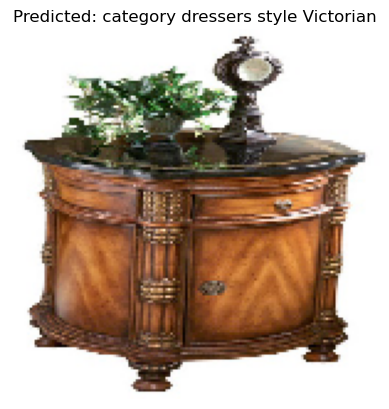

In [76]:
predict_single_image(image_path, model)

## Visualize random images

In this snippet we will choose 10 random pictures and classify their furniture type.

1/1 [==============================] - 0s 18ms/step


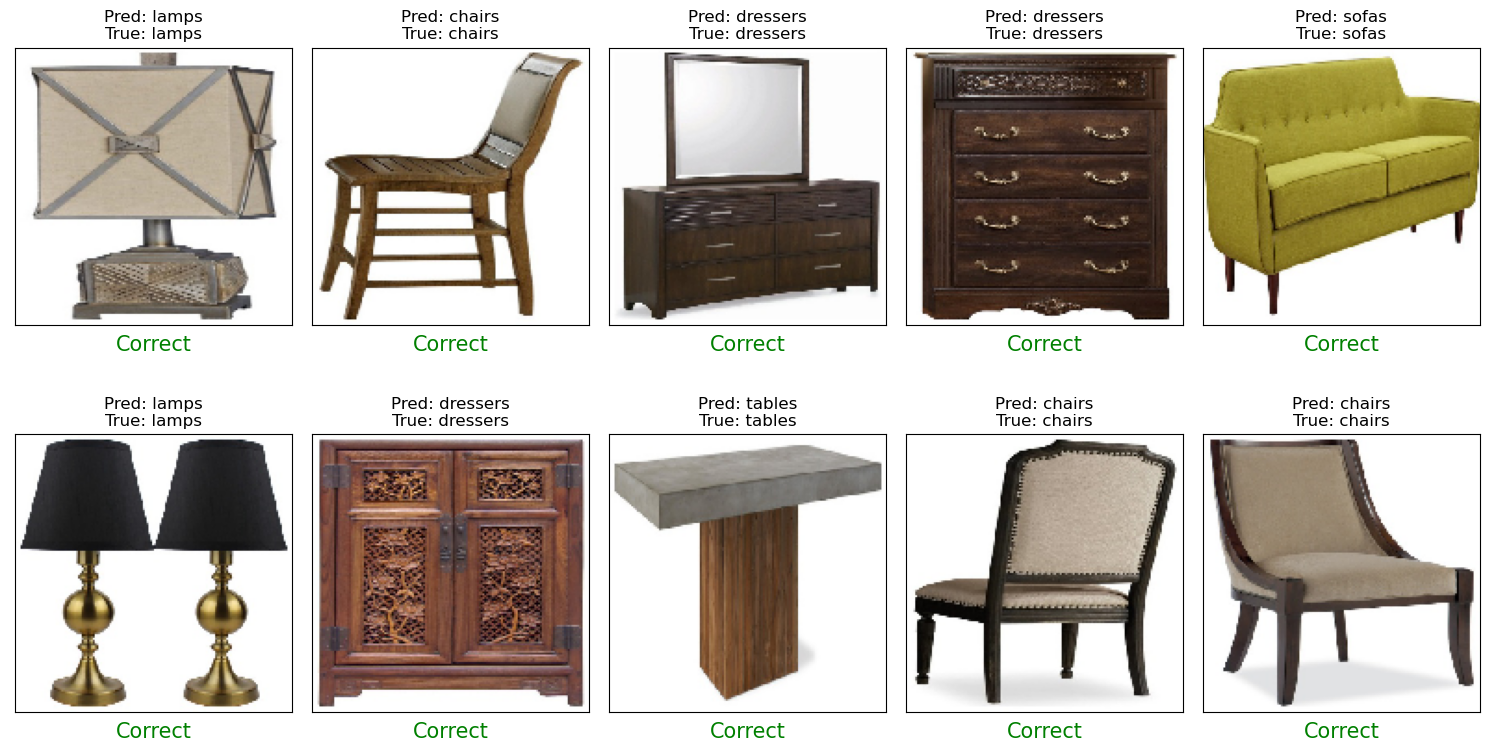

In [66]:
# Fetch 10 random batches from the test generator
random_images = []
random_truths = []
random_predictions = []
model = tf.keras.models.load_model('model2.h5')

for i in range(10):
    # Obtain a batch (since batch_size=1, this is one image)
    img, truth = next(test_generator)
    pred = model.predict(img)
    pred_label = np.argmax(pred, axis=1)  # Get the predicted class index
    
    # Store the data
    random_images.append(img[0])  # img[0] because batch_size=1
    random_truths.append(truth[0])  # Same as above
    random_predictions.append(pred_label[0])  # Decode the prediction

# If you have class indices to label mapping
label_map = {v: k for k, v in test_generator.class_indices.items()}
random_truth_labels = [label_map[np.argmax(t)] for t in random_truths]
random_pred_labels = [label_map[p] for p in random_predictions]

plt.figure(figsize=(15, 8))
plt.rc('axes', labelsize=15)  
for i, (image, truth, pred) in enumerate(zip(random_images, random_truth_labels, random_pred_labels)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Pred: {pred}\nTrue: {truth}")
    plt.xlabel("Correct" if pred == truth else "Incorrect", color="green" if pred == truth else "red")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

From the picture above we can tell that the classification part works well in our model. Therefore, we may continue with querying images now.

## Image Query

In this snippet we are going to load a picture from a user and classify it's category. 
After the picture is loaded, it undergoes the same processing steps as all the pictures in the dataset such as RGB value normalization.

In [7]:
model = tf.keras.models.load_model('model6_Task3.h5')
model.summary()

Model: "furniture_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 150, 150, 32  896         ['input_1[0][0]']                
                                )                                                     

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import cv2

def predict_single_image(image_path, model, target_size=(150, 150)):
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    
    img_array = img_to_array(img)  # Convert the image to a numpy array
    img_array = img_array / 255.0  # Normalize the image array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    
    # # Load the model if given as a path
    # if isinstance(model, str):
    #     model = load_model(model)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_category_index = np.argmax(prediction[0], axis=1)
    predicted_style_index = np.argmax(prediction[1], axis=1)
    
    predicted_category_name = train_datagen.class_le.inverse_transform(predicted_category_index)
    predicted_style_name = train_datagen.style_le.inverse_transform(predicted_style_index)
    print(predicted_category_name)
    print(predicted_style_name)
    # Optionally, decode the predictions
    # Assuming you have a mapping of class indices to labels
    # class_labels = {0: 'beds', 1: 'chairs', 2: 'dressers', 3: 'lamps', 4: 'sofas', 5: 'tables'}
    # predicted_label = class_labels[predicted_class[0]]
    # print(predicted_label)"
    # style_labels = {}

    # Display the image and the prediction
    plt.imshow(img)
    plt.title(f"Predicted: category {predicted_category_name} style {predicted_style_name}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

    return predicted_category_name, predicted_style_name


In [11]:
inference = FurnitureModelInference(train_datagen.class_le, train_datagen.style_le)
category_names, style_names = inference.predict_and_decode(model, input_data)

NameError: name 'FurnitureModelInference' is not defined

1/1 [==============================] - 0s 25ms/step
['dressers']
['Tropical']


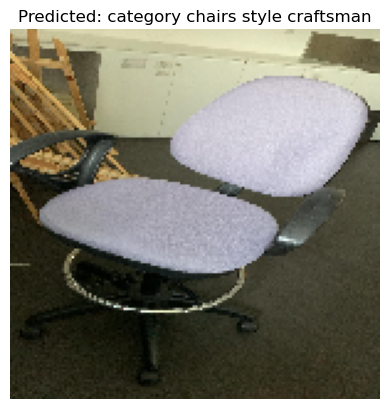

In [83]:
image_path = './query_image/5076765b-4af7-45f6-bce5-fdbc7f4cbd2b.jpg'
# model = tf.keras.models.load_model('model1.h5')
# Call the function
predicted_category, predicted_style = predict_single_image(image_path, model)
# print("Predicted Label:", predicted_label)


As we can see on the picture above, classification went successful.